In [1]:
"""
Trabalho computacional sobre algoritmos evolutivos para solução de sistemas de equações não lineares 
"""

'\nTrabalho computacional sobre algoritmos evolutivos para solução de sistemas de equações não lineares \n'

In [5]:
"""
Sistema de equações não lineares
"""
import numpy as np
import plotly.graph_objects as go
import pandas as pd

from src.equation_system import EquationSystem
from src.ga import real_coded_genetic_algorithm
from src.es import evolution_strategy
from src.comde import comde_algorithm

p1 = EquationSystem([
    lambda x: 0.8*(x[0]**2 + x[0] -1)*x[2] + 0.12*x[0]**2 + 2.16*x[0] - 0.12,
    lambda x: (1 + x[0]**2)*x[3] + 0.4*x[0]**2 - 1.6*x[0] - 0.4,
    lambda x: (1 + x[0]**2)*x[4] + x[0]**2 - 1,
    lambda x: (1 + x[0]**2)*x[5] + 0.8*(x[0]**2 + x[0] -1),
    lambda x: x[4]*x[6] - 0.02*x[5] - x[4] - x[2]*x[3] - 0.16*x[0],
    lambda x: x[6]**2 - 2*x[3]*x[6] + x[5]**2 + x[3]**2 - x[1]**2,
    lambda x: x[7] - x[1]*x[2],
    lambda x: 0.0476*x[2]*x[7]**12 + x[2] - 2.104
])

# p1 bounds
p1_lb = [-3, -1, -2, -1, -1, -0.5, -1.5, -1.5]
p1_ub = [1, 1, 2, 1, 1, 0.5, 1.5, 1.5]

p2 = EquationSystem([
    lambda x: x[4] + x[3] - 1.803,
    lambda x: (x[1] + x[2])*x[4] + 6.19116*x[3] - 1.803*(1.497 + 0.035),
    lambda x: x[5] + x[3] -0.328,
    lambda x: 0.28801*x[5] - x[1]*x[2]*x[4],
    lambda x: (-6.19116*x[0] + x[0]*x[2] + x[1]*x[4] - x[2]*x[4])*x[5] + x[0]*x[2]*x[4],
    lambda x: 1.571*x[6] + x[3] -1.803,
    lambda x: x[7] - 0.000856*x[6]**2,
    lambda x: (x[4] -x[0])*x[8] - x[0]*x[4],
    lambda x: x[8] - 377*x[1]*x[7]
])

# p2 bounds
p2_lb = [-0.5, -1, -1, -1, 1, -1, -1, 0, -1]
p2_ub = [0.5, 1, 1, 1, 2, 1, 1, 1, 1]

def save_results(score_histories, filename):
    df = pd.DataFrame(score_histories)
    df.columns = [f"iteration_{i}" for i in range(df.shape[1])]
    df = df.reset_index().rename(columns={"index": "epoch"})
    df.epoch = df.epoch + 1
    df.to_csv(filename, index=False)

### COMDE

#### Problema 1

In [7]:
bounds = np.asarray([p1_lb, p1_ub]).T
idxmin_comde_p1, best_individual_comde_p1, score_histories_comde_p1 = comde_algorithm(
    p1, bounds, 
    n_iter=2100, 
    pop_size=100, 
    F_initial=0.9, 
    F_final=0.1, 
    CR_initial=0.95, 
    CR_final=0.05, 
    k=0.5,
    R=0.5,
    epochs=10
)

save_results(score_histories_comde_p1, "results/score_histories_comde_p1.csv")

Generation 0000, Best: f([-2.66606203 -0.51631166  0.99472613 -0.73182042 -0.85882441 -0.41472691
Generation 0000, Best: f([-0.81667648 -0.73667443 -1.52855294 -0.18891055 -0.32866532  0.44955178
Generation 0000, Best: f([-0.10862277  0.13107141  0.09085592  0.69698393  0.50399751 -0.19447372
Generation 0000, Best: f([ 0.52733897  0.85852327  0.04582131  0.09069116  0.66167297 -0.19581416
Generation 0000, Best: f([-0.05738899 -0.57167644  0.9960956  -0.43037869  0.19664882 -0.47943422
Generation 0000, Best: f([ 0.2155278  -0.38714603  1.67014551  0.49992929 -0.18830549 -0.04996341
Generation 0000, Best: f([ 0.31645404 -0.5809098   1.10938426  0.28276518  0.10875094  0.32510505
Generation 0002, Best: f([ 0.31645404 -0.14930756  1.10938426  0.28276518  0.10875094  0.32510505
Generation 0006, Best: f([ 0.22109307 -0.84219401  0.59103811  0.77320375  0.44806839  0.42140409
Generation 0008, Best: f([ 0.2155278  -0.38714603  1.67014551  0.25147546  0.96657796  0.59415038
Generation 0009, Bes

In [8]:
fitness_scores = []
for i, history in enumerate(score_histories_comde_p1):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

[7.008282842946301e-16, 6.938893903907228e-16, 7.008282842946301e-16, 7.008282842946301e-16, 7.008282842946301e-16, 7.840255399074736e-05, 6.938893903907228e-16, 6.938893903907228e-16, 1.4918621893400541e-15, 6.938893903907228e-16]
\begin{tabular}{lr}
\toprule
Statistic & Value \\
\midrule
Best & 0.000000 \\
Worst & 0.000078 \\
Mean & 0.000008 \\
Standard Deviation & 0.000024 \\
Median & 0.000000 \\
\bottomrule
\end{tabular}



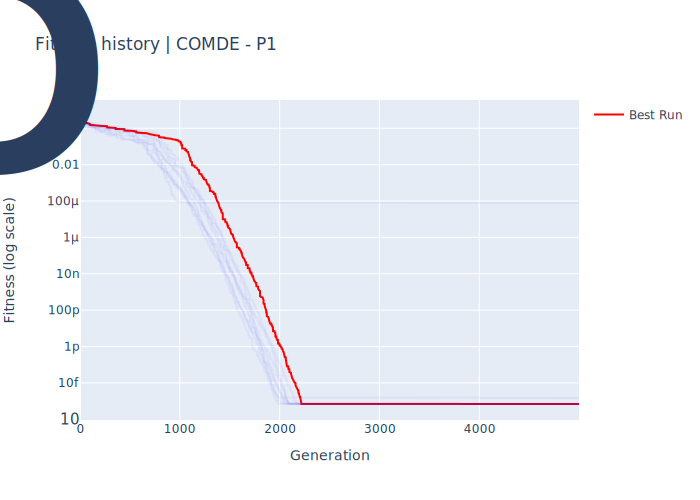

Best individual COMDE - P1: [array([0.28615066, 1.2925816 , 1.00462359, 0.76264142, 0.8486301 ,
       0.4673094 , 1.9677925 , 1.29855797]), 6.938893903907228e-16]
Best score P1: 6.938893903907228e-16


In [9]:
fig = go.Figure()
for i, history in enumerate(score_histories_comde_p1):
    if i == idxmin_comde_p1:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | COMDE - P1',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual COMDE - P1: {best_individual_comde_p1}')
print(f'Best score P1: {min(score_histories_comde_p1[idxmin_comde_p1])}')

#### Problema 2

In [ ]:
bounds = np.asarray([p2_lb, p2_ub]).T
idxmin_comde_p2, best_individual_comde_p2, score_histories_comde_p2 = comde_algorithm(
    p2, bounds, 
    n_iter=1500, 
    pop_size=100, 
    F_initial=0.9, 
    F_final=0.1, 
    CR_initial=0.95, 
    CR_final=0.05, 
    k=0.5,
    R=0.5,
    epochs=10
)

save_results(score_histories_comde_p2, "results/score_histories_comde_p2.csv")

In [ ]:
fitness_scores = []
for i, history in enumerate(score_histories_comde_p2):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

In [ ]:
fig = go.Figure()
for i, history in enumerate(score_histories_comde_p2):
    if i == idxmin_comde_p2:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | COMDE - P2',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual COMDE - P2: {best_individual_comde_p2}')
print(f'Best score P2: {min(score_histories_comde_p2[idxmin_comde_p2])}')

### GA

#### Problema 01

In [3]:
max_gen = 1000
epochs = 50
idxmin_ga_p1, best_individual_ga_p1, score_histories_ga_p1 = real_coded_genetic_algorithm(
    p1, p1_lb, p1_ub,
    pop_size=50,
    max_gen=max_gen,
    pc=0.8,
    pm=0.1,
    alpha=0.5,
    sigma=0.1,
    elitism=True,
    epochs=epochs,
)

save_results(score_histories_ga_p1, "results/score_histories_ga_p1.csv")

In [19]:
fitness_scores = []
for i, history in enumerate(score_histories_ga_p1):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

[1.0687362626395434, 0.9589972410616004, 1.0547049822586667, 0.9959069414008066, 0.7356384567236758, 0.9481928635406016, 0.11887641215769754, 1.0220626685677612, 0.22967667184763915, 0.6523662662891959, 0.10956073144485814, 1.2596051493321674, 0.8250527630390905, 0.9764685086867715, 0.5071026144947991, 0.8942453430972654, 0.47385422673211913, 0.2517214210309174, 0.2669107714186119, 0.9846177921554518, 0.27671243527108547, 1.0498766198109122, 0.353887519697406, 1.06528930066034, 0.8231955363959418, 0.4425577976874548, 0.1820299840327116, 0.35525638537540977, 0.630328296358277, 0.0876464794596978, 0.12350966862980572, 0.8684080006881888, 0.07428350828820537, 0.9895936449179541, 0.18955628998234078, 1.0564895491688602, 1.0708593400109043, 0.9182244708890765, 0.4568688475824999, 0.3671990216764055, 1.0695243685946951, 0.7433930047785765, 1.057445914926905, 1.0452574143529867, 0.24626532968986947, 0.46528441699535716, 0.15716973761044203, 0.17884753098679074, 0.10341000255108522, 0.08303794

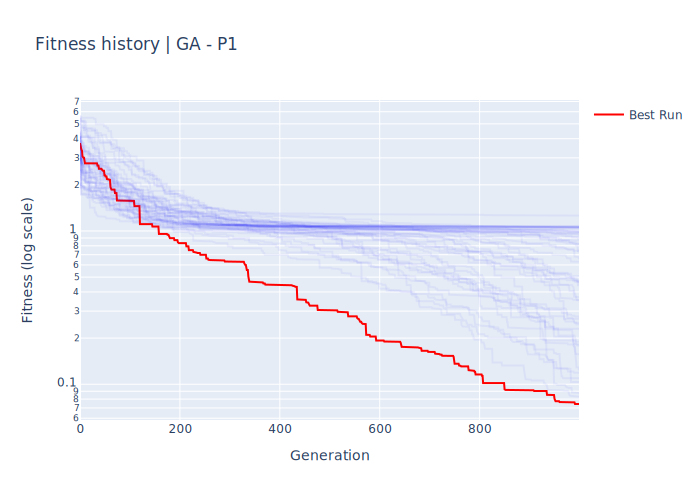

Best individual GA - P1: [ 0.29366173 -1.11328115  1.12232153  0.59122803  0.96781559  0.44723293
  1.61230343 -1.2727169 ]
Best score P1: 0.07428350828820537


In [15]:
fig = go.Figure()
for i, history in enumerate(score_histories_ga_p1):
    if i == idxmin_ga_p1:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | GA - P1',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual GA - P1: {best_individual_ga_p1}')
print(f'Best score P1: {min(score_histories_ga_p1[idxmin_ga_p1])}')

#### Problema 02

In [5]:
idxmin_ga_p2, best_individual_ga_p2, score_histories_ga_p2 = real_coded_genetic_algorithm(
    p2, p2_lb, p2_ub,
    pop_size=50,
    max_gen=1000,
    pc=0.8,
    pm=0.1,
    alpha=0.5,
    sigma=0.1,
    elitism=True,
    epochs=50,
)

save_results(score_histories_ga_p2, "results/score_histories_ga_p2.csv")

In [20]:
fitness_scores = []
for i, history in enumerate(score_histories_ga_p2):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

[0.036333885403559085, 0.008162798886989519, 0.013513825477740155, 0.003983162917102435, 0.009658163385868274, 0.006715245471850345, 0.03314815171087744, 0.006961913334499218, 0.006775738601340832, 0.026512757434665874, 0.5173770288447703, 0.009605567492391822, 0.01541192906111124, 0.2423843084635447, 0.011710164673208043, 0.02741032425596395, 0.006527361625348137, 0.01802055892787245, 0.27757526206465355, 0.04007803605660852, 0.017289081530712444, 0.002576561722642275, 0.007384706514812963, 0.013190574096149243, 0.011905402542322368, 0.026296953865371016, 0.0065822763237630205, 0.5376053641204431, 0.04161953086029716, 0.014478281574478754, 0.006992088484587894, 0.023636008456997707, 0.011016199603048055, 0.011348170704628197, 0.022972939594690874, 0.00908849647345325, 0.08977581711123209, 0.008412136656398032, 0.007749608421793847, 0.03659223800527347, 0.01028155116235868, 0.016649757864359026, 0.0025781188682097458, 0.023103987051974275, 0.005184820288845494, 0.01934579332482802, 0.0

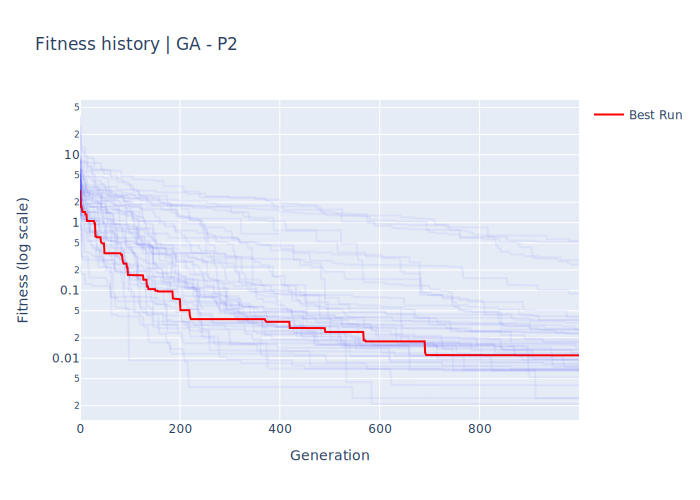

Best individual GA - P2: [-0.04396227 -0.03576887  0.23183005  0.39872151  1.42315963 -0.05490238
  0.89970371  0.00353653 -0.06294387]
Best score P2: 0.17884753098679074


In [13]:
fig = go.Figure()
for i, history in enumerate(score_histories_ga_p2):
    if i == idxmin_ga_p1:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | GA - P2',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual GA - P2: {best_individual_ga_p2}')
print(f'Best score P2: {min(score_histories_ga_p1[idxmin_ga_p2])}')

### Evolution Strategy

#### Problema 01

In [7]:
idxmin_es_p1, best_individual_es_p1, best_score_es_p1, score_histories_es_p1 = evolution_strategy(
    p1, p1_lb, p1_ub,
    n_iter=5000,
    step_size=0.15,
    mu=20,
    lam=100,
    epochs=50,
)
save_results(score_histories_es_p1, "results/score_histories_es_p1.csv")

Epoch 0000, Best: f([-0.19861455 -0.0052665  -0.39262433 -0.23820892  0.61480616 -0.27573766
Epoch 0000, Best: f([-0.20208023  0.51940269 -0.01938122 -0.56732142 -0.10275354  0.26157496
Epoch 0000, Best: f([ 0.23950698  0.69860554  1.32484737  0.44884251  0.43421647 -0.39137122
Epoch 0000, Best: f([ 0.23879036 -0.03511259  1.2194825  -0.4921996  -0.19162768  0.40918876
Epoch 0000, Best: f([ 0.22042674 -0.68648852  0.12008931  0.9769816   0.91734857  0.32894881
Epoch 0000, Best: f([ 0.43784806 -0.83476704  1.19406312  0.92430568  0.4099562   0.32613687
Epoch 0001, Best: f([ 0.32191617 -0.79221878  1.21522648  0.76974091  0.50550314  0.1274249
Epoch 0002, Best: f([ 0.41206167 -0.60711879  1.02129506  0.76908807  0.52235195  0.2525454
Epoch 0003, Best: f([ 0.41101565 -0.52349901  0.96594442  0.82950533  0.64910047  0.43443309
Epoch 0003, Best: f([ 0.30844735 -0.52630646  1.57317734  0.75674567  0.14938784  0.22663775
Epoch 0003, Best: f([ 0.26164843 -0.50474938  1.12274879  0.5930857   0.

In [21]:
fitness_scores = []
for i, history in enumerate(score_histories_es_p1):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

[0.21329004171354776, 0.2297208037514607, 0.201115180536722, 0.20559009639570008, 0.19035350327124093, 0.18120060006661376, 0.20386260084531077, 0.17704070699255814, 0.21167589093694225, 0.24093556087735818, 0.18931413347234027, 0.21900595488726604, 0.21030401804134635, 0.19239604102120145, 0.21748725997134277, 0.20761791420194653, 0.2077078532022968, 0.23833770831135329, 0.21062238106258208, 0.1999040344994201, 0.18047677535677636, 0.2157782312192829, 0.20103111749995278, 0.2081331799077209, 0.23197269433233805, 0.21371590822976821, 0.15818082388575724, 0.23978097683418007, 0.22405132646392528, 0.19633221033463666, 0.19764409972912855, 0.1970529463859505, 0.2391808204098254, 0.19621634993860287, 0.19336810830623238, 0.18204119699382854, 0.21663257646008013, 0.21610850127359083, 0.22625587310576006, 0.19801507539707, 0.22024106750568134, 0.20236745163409797, 0.20359210179775322, 0.18509596465973804, 0.21442817901393812, 0.20820069875659225, 0.20375257195236468, 0.20128635622345173, 0.2

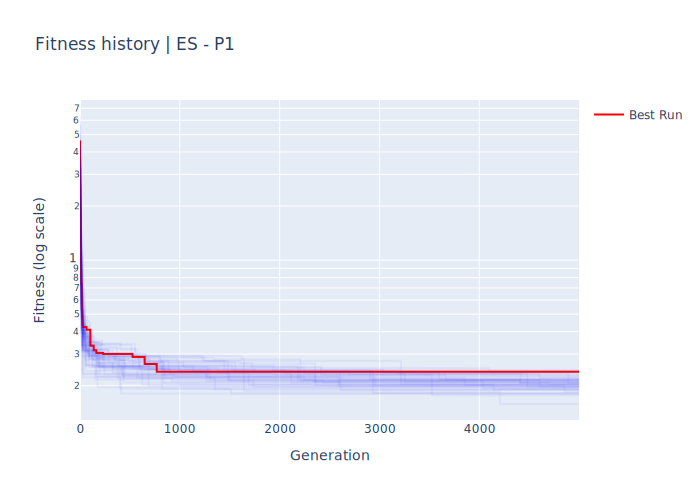

Best individual ES - P1: [ 0.28262201 -0.98185698  1.15443525  0.54992335  0.96410071  0.46413603
  1.46611223 -1.26916243]
Best score P1: 0.15818082388575724


In [11]:
fig = go.Figure()
for i, history in enumerate(score_histories_es_p1):
    if i == idxmin_ga_p1:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | ES - P1',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual ES - P1: {best_individual_es_p1}')
print(f'Best score P1: {min(score_histories_es_p1[idxmin_es_p1])}')

#### Problema 02

In [9]:
idxmin_es_p2, best_individual_es_p2, best_score_es_p2, score_histories_es_p2 = evolution_strategy(
    p2, p2_lb, p2_ub,
    n_iter=5000,
    step_size=0.15,
    mu=20,
    lam=100,
    epochs=50,
)

save_results(score_histories_es_p2, "results/score_histories_es_p2.csv")

Epoch 0000, Best: f([ 0.13840603  0.02370669 -0.15707088  0.68813533  1.65983931 -0.70444281
Epoch 0001, Best: f([ 0.18706173  0.06438315 -0.31629305  0.66449675  1.91019109 -0.58280871
Epoch 0002, Best: f([ 4.05505734e-01 -8.91760770e-04 -4.65767665e-01  6.25118142e-01
  1.91089660e+00 -7.97968699e-01  9.47073074e-01  1.05011220e-01
Epoch 0002, Best: f([ 0.05190954 -0.00905773 -0.25070306  0.61293569  1.79672087 -0.50571298
Epoch 0003, Best: f([ 0.01425791  0.00951614 -0.35282128  0.64956913  1.77253288 -0.37228837
Epoch 0004, Best: f([ 0.30230152  0.1153065  -0.61490485  0.66260679  1.83955179 -0.59487397
Epoch 0008, Best: f([-0.0053534   0.02162208 -0.51214841  0.52950709  1.17866485 -0.176654
Epoch 0009, Best: f([ 0.11593182  0.01912081 -0.61520518  0.57050022  1.44061227 -0.12871999
Epoch 0085, Best: f([0.2122183  0.05894235 0.31684444 0.39192466 1.50166276 0.01311717
Epoch 0772, Best: f([-0.05527706 -0.00349731  0.05453721  0.43799022  1.19897645 -0.04164207
Epoch 1181, Best: f([

In [22]:
fitness_scores = []
for i, history in enumerate(score_histories_es_p2):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

[0.038728290761349475, 0.040674544611167575, 0.0237727413772662, 0.03377816272037128, 0.03559126184099894, 0.028783561242095086, 0.03456492898795693, 0.048737583988508706, 0.03164221639265147, 0.030895584020554475, 0.04478185071182367, 0.03657955848779392, 0.049227914585040965, 0.04359031978250387, 0.05221710789373978, 0.05178643379155007, 0.02736742293768827, 0.05704199790286541, 0.07459154164546758, 0.06060982014148064, 0.025016987250857402, 0.030482398255664175, 0.0365542955444043, 0.04006811499776016, 0.044201687017974965, 0.05383633596222863, 0.02448629103101124, 0.05510826823076377, 0.03473377148579054, 0.05235880687031461, 0.023865350200254987, 0.04731678958928814, 0.04541709570417802, 0.05747145095136091, 0.03470155675212662, 0.05986206525732221, 0.04334259602966737, 0.0425878283584789, 0.043011879665609716, 0.04361340982577197, 0.025849745109699895, 0.017096371339647934, 0.04417962816623884, 0.008296948274236599, 0.04386901885920068, 0.041415618963316074, 0.022567257818381203,

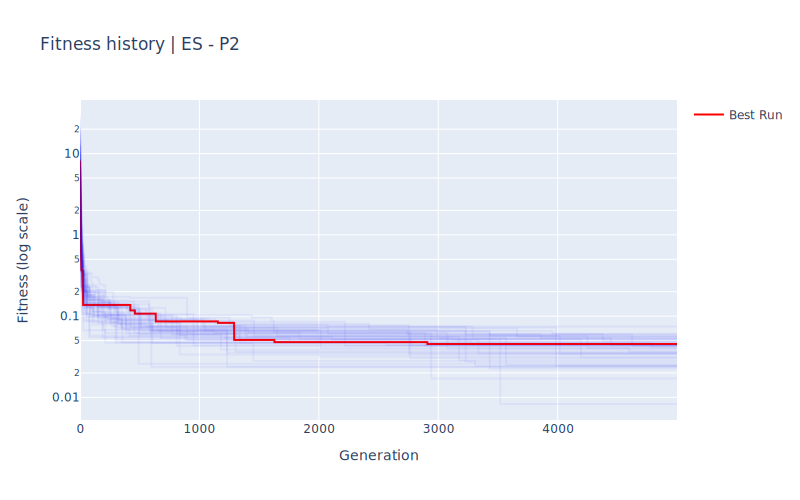

Best individual ES - P2: [-0.05205448  0.00339483  0.00635494  0.44729773  1.3119237  -0.07354691
  0.878052    0.00247846 -0.01870831]
Best score P2: 0.008296948274236599


In [23]:
fig = go.Figure()
for i, history in enumerate(score_histories_es_p2):
    if i == idxmin_ga_p1:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | ES - P2',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)
fig.update_layout(width=800, height=500)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual ES - P2: {best_individual_es_p2}')
print(f'Best score P2: {min(score_histories_es_p2[idxmin_es_p2])}')